Evaluating...


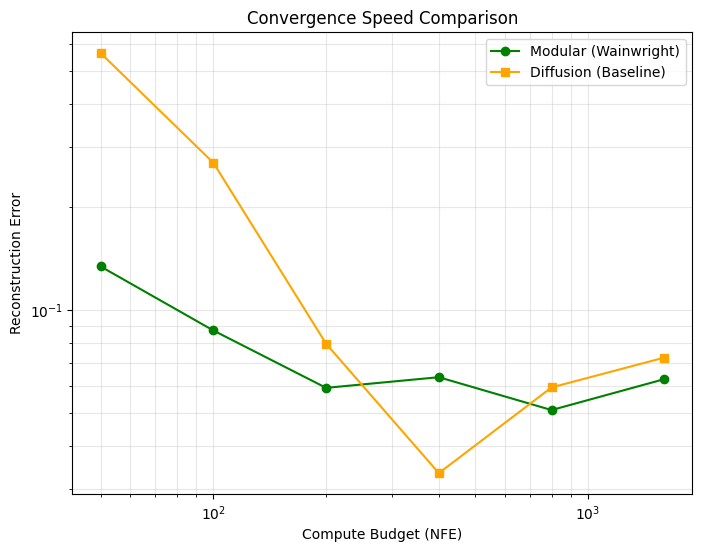

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

np.random.seed(13)


# --- 1. Target Distribution & Exact Score ---
class GaussianMixture:
    def __init__(self, means, covs, weights):
        self.means = np.array(means)
        self.covs = np.array(covs)
        self.weights = np.array(weights) / np.sum(weights)
        self.dim = self.means.shape[1]
        self.n_components = len(weights)

    def get_score_and_logprob(self, x, alpha_sq, sigma_sq):
        if alpha_sq < 1e-9:
            alpha_sq = 1e-9
        current_means = np.sqrt(alpha_sq) * self.means
        current_covs = (alpha_sq * self.covs) + sigma_sq * np.eye(self.dim)[None, :, :]

        log_probs, grads = [], []
        for i in range(self.n_components):
            diff = x - current_means[i]
            inv_cov = np.linalg.inv(current_covs[i])
            exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
            sign, logdet = np.linalg.slogdet(current_covs[i])
            norm_const = -0.5 * (self.dim * np.log(2 * np.pi) + logdet)
            log_probs.append(exponent + norm_const)
            grads.append(-(diff @ inv_cov))

        log_probs = np.array(log_probs)
        grads = np.array(grads)

        weighted_log_probs = log_probs + np.log(self.weights)[:, None]
        max_log = np.max(weighted_log_probs, axis=0)
        denom = max_log + np.log(np.sum(np.exp(weighted_log_probs - max_log), axis=0))
        resps = np.exp(weighted_log_probs - denom)
        score = np.sum(resps[:, :, None] * grads, axis=0)
        return score, denom

    def get_marginal_score(self, x, alpha_sq, sigma_sq):
        s, _ = self.get_score_and_logprob(x, alpha_sq, sigma_sq)
        return s


target = GaussianMixture(
    means=[[-2, -2], [2, 2]], covs=[[[0.3, 0], [0, 0.3]]] * 2, weights=[0.5, 0.5]
)


# --- 2. Adaptive Schedule (Modular Scheme) ---
def get_adaptive_schedule(B_max, K_limit=100):
    a_list = [1.0 / np.sqrt(2)]
    theta_sq = a_list[0] ** 2
    for k in range(K_limit):
        lam = 4 * B_max * theta_sq
        a_sq = (2 * lam + 2) / (2 * lam + 3)
        a_list.append(np.sqrt(a_sq))
        theta_sq *= a_sq
        if theta_sq <= 1.0 / (8 * B_max):
            break
    return np.array(a_list)


# --- 3. Dynamic Step Allocation ---
def allocate_dynamic_steps(schedule, total_nfe):
    K = len(schedule)
    loop_coeffs = []
    for k in range(K - 1, -1, -1):
        M_k = np.prod(1.0 / schedule[: k + 1]) if k > 0 else 1.0
        loop_coeffs.append(np.sqrt(M_k))
    loop_coeffs = np.array(loop_coeffs)
    step_counts = (loop_coeffs / np.sum(loop_coeffs)) * total_nfe
    step_counts = np.maximum(step_counts, 2).astype(int)
    diff = total_nfe - np.sum(step_counts)
    if diff > 0:
        step_counts[:diff] += 1
    return step_counts


# --- 4. Modular Sampler (MALA) ---
def run_modular(target, schedule, total_nfe, n_samples=200):
    K = len(schedule)
    if total_nfe < K:
        return np.random.randn(n_samples, 2) * 5
    steps_per_stage = allocate_dynamic_steps(schedule, total_nfe)
    y = np.random.randn(n_samples, 2)

    for idx, k in enumerate(range(K - 1, -1, -1)):
        n_sub = steps_per_stage[idx]
        a = schedule[k]
        b = np.sqrt(1 - a**2)
        y_curr = y / a
        curr_alph_sq = np.prod(schedule[:k] ** 2) if k > 0 else 1.0
        eta = 0.1

        for _ in range(n_sub):
            z = np.random.randn(n_samples, 2)
            s_marg, logp_marg = target.get_score_and_logprob(
                y_curr, curr_alph_sq, 1.0 - curr_alph_sq
            )
            diff = y - a * y_curr
            logp_trans = -0.5 * np.sum(diff**2, axis=1) / b**2
            s_trans = (a / b**2) * diff
            score_total = s_marg + s_trans
            logp_total = logp_marg + logp_trans

            y_prop = y_curr + eta * score_total + np.sqrt(2 * eta) * z

            s_marg_p, logp_marg_p = target.get_score_and_logprob(
                y_prop, curr_alph_sq, 1.0 - curr_alph_sq
            )
            diff_p = y - a * y_prop
            logp_trans_p = -0.5 * np.sum(diff_p**2, axis=1) / b**2
            s_trans_p = (a / b**2) * diff_p
            score_total_p = s_marg_p + s_trans_p
            logp_total_p = logp_marg_p + logp_trans_p

            log_q_fwd = (
                -0.5
                * np.sum((y_prop - (y_curr + eta * score_total)) ** 2, axis=1)
                / (2 * eta)
            )
            log_q_bwd = (
                -0.5
                * np.sum((y_curr - (y_prop + eta * score_total_p)) ** 2, axis=1)
                / (2 * eta)
            )

            log_acc = (logp_total_p + log_q_bwd) - (logp_total + log_q_fwd)
            acc = np.exp(np.minimum(0, log_acc))
            mask = np.random.rand(n_samples) < acc
            y_curr[mask] = y_prop[mask]
        y = y_curr
    return y


# --- 5. Diffusion Sampler ---
def run_diffusion(target, nfe, n_samples=200):
    n_steps = nfe
    betas = np.linspace(0.0001, 0.02, n_steps)
    alphas = 1 - betas
    alph_bar = np.cumprod(alphas)
    x = np.random.randn(n_samples, 2)

    for t in range(n_steps - 1, -1, -1):
        z = np.random.randn(n_samples, 2) if t > 0 else 0
        sc = target.get_marginal_score(x, alph_bar[t], 1 - alph_bar[t])
        mean = (1 / np.sqrt(alphas[t])) * (x + betas[t] * sc)
        x = mean + np.sqrt(betas[t]) * z
    return x


# --- 6. Run Experiment ---
def calculate_error(samples, true_means):
    dists = cdist(samples, true_means)
    labels = np.argmin(dists, axis=1)
    err = 0.0
    valid = 0
    for i in range(len(true_means)):
        subset = samples[labels == i]
        if len(subset) > 0:
            err += np.linalg.norm(np.mean(subset, axis=0) - true_means[i])
            valid += 1
        else:
            err += 5.0
    return err / max(valid, 1)


B_max = 5.0
schedule = get_adaptive_schedule(B_max)
budgets = [50, 100, 200, 400, 800, 1600]
res_mod, res_diff = [], []

print("Evaluating...")
for b in budgets:
    errs_m = [
        calculate_error(run_modular(target, schedule, b), target.means)
        for _ in range(3)
    ]
    errs_d = [calculate_error(run_diffusion(target, b), target.means) for _ in range(3)]
    res_mod.append(np.mean(errs_m))
    res_diff.append(np.mean(errs_d))

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(budgets, res_mod, "o-", label="Modular (Wainwright)", color="green")
plt.plot(budgets, res_diff, "s-", label="Diffusion (Baseline)", color="orange")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Compute Budget (NFE)")
plt.ylabel("Reconstruction Error")
plt.title("Convergence Speed Comparison")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()